#Sarcasm Detector

In [1]:
#!pip uninstall tensorflow
!pip install tensorflow
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive

drive.mount('/content/gDrive/', force_remount=True)

Mounted at /content/gDrive/


In [4]:
DS1=pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1',header=None)

In [5]:
#preprocess data
DS1.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#just keeping tweets and polarity as sentiment
DS1=DS1[[5,0]]
DS1.columns=['tweets','sentiment']
DS1.head()

,tweets,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
DS1.tail()
# (0 = negative, 4 = positive)

,tweets,sentiment
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,4


In [8]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('/content/gDrive/My Drive/Colab/Dissertation/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [9]:
nltk.download('punkt');

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
def CToken(df):
    tweet_lines = list()
    lines = DS1["tweets"].values.tolist()

    for line in lines:
        line = preprocess_apply(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        tweet_lines.append(words)
    return tweet_lines

tweet_lines = CToken(DS1)
tweet_lines[0:10]

[['user',
  'url',
  'aww',
  'thatis',
  'bummer',
  'shoulda',
  'got',
  'david',
  'carr',
  'third',
  'day',
  'smile'],
 ['upset',
  'update',
  'facebook',
  'texting',
  'might',
  'cry',
  'result',
  'school',
  'today',
  'also',
  'blah'],
 ['user',
  'dived',
  'many',
  'times',
  'ball',
  'managed',
  'save',
  'rest',
  'go',
  'bounds'],
 ['whole', 'body', 'feels', 'itchy', 'like', 'fire'],
 ['user', 'behaving', 'mad', 'see'],
 ['user', 'whole', 'crew'],
 ['need', 'hug'],
 ['user',
  'hey',
  'long',
  'time',
  'see',
  'yes',
  'rains',
  'bit',
  'bit',
  'lol',
  'fine',
  'thanks'],
 ['user', 'nope'],
 ['user', 'que', 'muera']]

In [12]:
#train-test split again for detector
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweet_lines)
sequences = tokenizer_obj.texts_to_sequences(tweet_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  DS1['sentiment'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]



unique tokens -  253257
vocab size - 253258


In [13]:
#using label encoder for ordering each label to train and test.

lb=LabelEncoder()
Y = lb.fit_transform(y_train)
Y2 = lb.fit_transform(y_test)

In [14]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (1280000, 25)
Shape of y_train: (1280000,)
Shape of X_test_pad: (320000, 25)
Shape of y_test: (320000,)


In [15]:
#load Global vectors
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "/content/gDrive/My Drive/Colab/Dissertation/"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [16]:
#building embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

124492


In [17]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [18]:
#build the RNN
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           25325800  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 25,368,105
Trainable params: 42,305
Non-trainable params: 25,325,800
_________________________________________________________________
None


In [19]:
#train
history = model.fit(X_train_pad, Y, batch_size=32, epochs=20, validation_data=(X_test_pad, Y2), verbose=2)

Epoch 1/20
40000/40000 - 922s - loss: 0.4761 - acc: 0.7701 - val_loss: 0.4476 - val_acc: 0.7882 - 922s/epoch - 23ms/step
Epoch 2/20
40000/40000 - 917s - loss: 0.4544 - acc: 0.7838 - val_loss: 0.4424 - val_acc: 0.7923 - 917s/epoch - 23ms/step
Epoch 3/20
40000/40000 - 917s - loss: 0.4491 - acc: 0.7868 - val_loss: 0.4366 - val_acc: 0.7951 - 917s/epoch - 23ms/step
Epoch 4/20
40000/40000 - 917s - loss: 0.4460 - acc: 0.7888 - val_loss: 0.4346 - val_acc: 0.7954 - 917s/epoch - 23ms/step
Epoch 5/20
40000/40000 - 942s - loss: 0.4444 - acc: 0.7898 - val_loss: 0.4340 - val_acc: 0.7969 - 942s/epoch - 24ms/step
Epoch 6/20
40000/40000 - 949s - loss: 0.4433 - acc: 0.7904 - val_loss: 0.4321 - val_acc: 0.7970 - 949s/epoch - 24ms/step
Epoch 7/20
40000/40000 - 956s - loss: 0.4421 - acc: 0.7911 - val_loss: 0.4343 - val_acc: 0.7959 - 956s/epoch - 24ms/step
Epoch 8/20
40000/40000 - 932s - loss: 0.4419 - acc: 0.7909 - val_loss: 0.4313 - val_acc: 0.7983 - 932s/epoch - 23ms/step
Epoch 9/20
40000/40000 - 992s - 

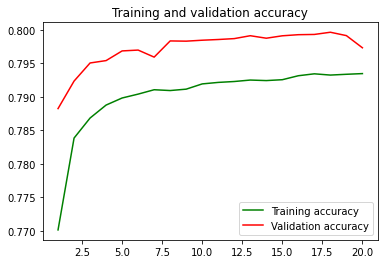

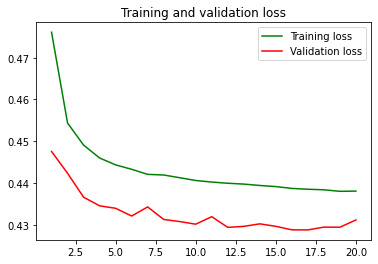

In [20]:

#plotting the results by visualization
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
#using multinomial Naive Bayes for accuracy
model = MultinomialNB().fit(X_train_pad, Y)
y_pred = model.predict(X_test_pad)

In [22]:
print('Accuracy:', accuracy_score(Y2, y_pred))
print('F1 score:', f1_score(Y2, y_pred, average="macro"))
print('ROC AUC:', roc_auc_score(Y2, y_pred,multi_class='ovr'))

Accuracy: 0.53181875
F1 score: 0.5177555538695578
ROC AUC: 0.5317111641009994


In [28]:
#Try prediction
def sarcasm(s):
    x_final = pd.DataFrame({"tweets":[s]})
    test_lines = CToken(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "Detected sarcasm!" 
    else: return "Detected no sarcasm."

In [29]:
sarcasm("I want a million dollars!")


'Detected no sarcasm.'

pure sarcasm

In [30]:
sarcasm("Silence is golden. Duct tape is silver.")

'Detected no sarcasm.'